# Gamma Scalping I: Theory

Recently I came across this concept of "Gamma Scalping". Although I always claim that I know option pricing, I have to admit that I've never really thought about option strategies before. So since this was brought up, I decided to take a deeper look of this strategy.

The plan is to study this thing in 2 parts, theoretically and practically. For the theoretical part, I'll try to figure out how gamma scalping works with some fake scenarios. For the practical part, I'll find some real data to test this strategy's performance, which will come as a separate notebook.

### Theoretical Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('D:\\Projects\\Derivative Pricing\\')

Here I'm using the result of my other project, the derivative pricing system. It was initially developed to practice the OOP concept, but comes handy with option related utilities.

In [3]:
import DataObj as DO
import TradableObj as TO
import OptionObj as options
import MarketObj as MO
import PayoffObj as PO
import datetime

I'm taking GS euqity data as the underlying, from 2017 up to 2018 August.

In [4]:
io =  DO.myIO()
data = io.read('GS', 'iex', start = datetime.datetime(2017,1,1), end = None)

2y


In [5]:
data.head()

,open,high,low,close,volume
date,,,,,
2017-01-03,238.1675,240.3951,233.5258,237.0586,4384246
2017-01-04,236.9310,238.7759,235.5474,238.5895,2728709
2017-01-05,238.1871,238.6900,232.3581,236.8133,3562618
2017-01-06,237.7652,241.6021,236.8623,240.3264,3591079
2017-01-09,238.7072,240.1203,236.9605,238.3539,3022766


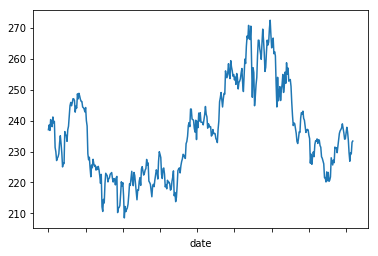

In [6]:
data.close.plot()

In [7]:
# A market object contains information that we get from the market.
# i.e. stock price, interest rate, implied volatility.
market = MO.myMarket()
market.save_data(data[['close']], 'GS')

Market data for GS has been added!


In [8]:
# Here I'm assuming constant interest rate, dividend and implied volatility.
# This will be relaxed later.
ir = lambda x: 0.01
iv = lambda x: 0.20
iq = lambda x: 0.0
interest_rate = {}
implied_vol = {}
dividend = {}
for t in data.index:
    t = pd.Timestamp(t)
    interest_rate[t] = ir
    implied_vol[t] = iv
    dividend[t] = iq
market.save_data(interest_rate, 'DOM_IR')
market.save_data(implied_vol, 'GS_IV')
market.save_data(dividend, 'GS_DIV')

Market data for DOM_IR has been added!
Market data for GS_IV has been added!
Market data for GS_DIV has been added!


In [9]:
# Make a stock with GS data
Stock = TO.equity('GS', market)

My option data will be a really simple European option, and the contract object contains trade specific informaiton:
i.e. expiration, strike, call put type, etc.

In [10]:
Contract = PO.payoff(250, datetime.datetime(2018,10,1), True)

In [11]:
Option = options.European_Option('O_GS_C_20181001_250', Stock, Contract, market)

Test the utilities a little bit, see if we can price, and see if the pricing makes sense.

In [12]:
date = '2017-12-28'
print(Stock.spot(date))
print(Option.dollar_price(date))
print(Option.delta(date))
print(Option.gamma(date))
print(Option.theta(date))
print(Option.rho(date))
print(Option.vega(date))

[254.8807]
[21.05168627]
[0.59547224]
[0.00872509]
[-12.64359332]
[99.20599083]
[86.03215019]


#### Now let's go into the main part of this study, explaining gamma scalping.

In [13]:
# Strategy has the gamma scalping PNL. At day 0 we assume 0 initial investment, use cash to finance the option and hedge.
Strategy = pd.DataFrame(np.NaN, index = data.index, 
                        columns = ['Option', 'Stock', 'Cash', 'Portfolio'])

In [14]:
Greeks = pd.DataFrame(np.NaN, index = data.index, 
                      columns = ['Price', 'Delta', 'Gamma','Theta'])
for i, date_idx in enumerate(Greeks.index):
    Greeks.iloc[i,:].Price = Option.dollar_price(date_idx)
    Greeks.iloc[i,:].Delta = Option.delta(date_idx)
    Greeks.iloc[i,:].Gamma = Option.gamma(date_idx)
    Greeks.iloc[i,:].Theta = Option.theta(date_idx)

In [15]:
Greeks.head()

,Price,Delta,Gamma,Theta
date,,,,
2017-01-03,21.267044,0.498671,0.006374,-8.133895
2017-01-04,22.015434,0.508280,0.006337,-8.207400
2017-01-05,21.100374,0.496853,0.006391,-8.133717
2017-01-06,22.862402,0.519024,0.006295,-8.290863
2017-01-09,21.783375,0.506189,0.006369,-8.225648


In [16]:
Greeks.tail()

,Price,Delta,Gamma,Theta
date,,,,
2018-08-13,0.781676,0.101956,0.010707,-11.244230
2018-08-14,1.060778,0.131004,0.012774,-13.752939
2018-08-15,0.984030,0.124352,0.012466,-13.378769
2018-08-16,1.497959,0.173967,0.015523,-17.245448
2018-08-17,1.516832,0.176978,0.015841,-17.653700


In [17]:
for i, date_idx in enumerate(Strategy.index):
    """
    We maintain 1 unit long call, and apply dynamic hedging of delta for each day.
    Assume on day 1 we have a 0 worth portfolio, financing any trade with cash.
    """
    Strategy.iloc[i,:].Option = Greeks.loc[date_idx, 'Price']
    hedge = - Greeks.loc[date_idx, 'Delta']
    Strategy.iloc[i,:].Stock = hedge * Stock.spot(date_idx)
    if i == 0:
        Strategy.iloc[i,:].Cash = 0 - Strategy.iloc[i,:].Option - Strategy.iloc[i,:].Stock
    else:
        Strategy.iloc[i,:].Cash = Strategy.iloc[i-1,:].Cash - (hedge - (-Greeks.iloc[i-1,:].Delta)) * Stock.spot(date_idx)
    Strategy.iloc[i,-1] = sum(Strategy.iloc[i,:-1])

In [18]:
Strategy.head()

,Option,Stock,Cash,Portfolio
date,,,,
2017-01-03,21.267044,-118.214216,96.947172,0.000000
2017-01-04,22.015434,-121.270231,99.239772,-0.015025
2017-01-05,21.100374,-117.661416,96.533763,-0.027279
2017-01-06,22.862402,-124.735197,101.862050,-0.010746
2017-01-09,21.783375,-120.652123,98.802751,-0.065997


Now we can see the delta hedged portfolio's PNL. As expected, the strategy is not super profitable, for most of the time, it is even losing money, but it does have a couple of spikes. 

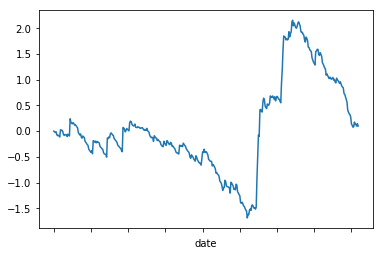

In [19]:
Strategy.Portfolio.plot()

For these days we have > 0.1 profit for the strategy.

In [20]:
Strategy.loc[Strategy.Portfolio.diff()>0.1,]

,Option,Stock,Cash,Portfolio
date,,,,
2017-01-17,18.216993,-106.331406,88.140961,0.026548
2017-02-03,20.268982,-116.028236,95.999441,0.240187
2017-03-21,15.897022,-99.644876,83.562763,-0.185092
2017-04-18,8.954567,-65.425827,56.335704,-0.135556
2017-05-17,7.874480,-60.374400,52.570886,0.070966
2017-05-31,7.143155,-56.481481,49.503806,0.165480
2017-07-18,9.824589,-75.305540,65.391745,-0.089206
2017-08-04,11.758196,-87.554856,75.599211,-0.197449
2017-09-05,7.278326,-62.290483,54.738354,-0.273804


Here we analyze why we lost money for most of the days, and what are the characteristics are the days that we made money. We initialize an "Others" dataframe to record the model implied option price change and real option price change. Specifically, we'll focus on Delta, Gamma, Theta and ignore Rho and Vega, since we are holding them for constant.

In [21]:
Others = pd.DataFrame(np.NaN, index = data.index, 
      columns = ['Stock_Price_Change', 'Option_Price_Change','Delta_Con', 'Gamma_Con','Theta_Con', 'After_hedge']
)
for i, date_idx in enumerate(Others.index):
    if i == 0: continue
    Others.iloc[i,:].Stock_Price_Change = Stock.spot(date_idx) - Stock.spot(Others.index[i-1])
    Others.iloc[i,:].Option_Price_Change = Greeks.loc[date_idx, 'Price'] - Greeks.loc[Greeks.index[i-1], 'Price']
    Others.iloc[i,:].Delta_Con = Greeks.loc[Greeks.index[i-1], 'Delta'] * Others.iloc[i,:].Stock_Price_Change
    Others.iloc[i,:].Gamma_Con = Greeks.loc[Greeks.index[i-1], 'Gamma'] * \
                    Others.iloc[i,:].Stock_Price_Change **2 / 2
    Others.iloc[i,:].Theta_Con = Greeks.loc[Greeks.index[i-1], 'Theta'] * \
                    ((pd.Timestamp(date_idx) - pd.Timestamp(Others.index[i-1]))/datetime.timedelta(days = 365))
    Others.iloc[i,-1] = sum(Others.iloc[i,3:5])

In [22]:
Others.head(10)

,Stock_Price_Change,Option_Price_Change,Delta_Con,Gamma_Con,Theta_Con,After_hedge
date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1.5309,0.748390,0.763415,0.007470,-0.022285,-0.014815
2017-01-05,-1.7762,-0.915060,-0.902807,0.009997,-0.022486,-0.012490
2017-01-06,3.5131,1.762028,1.745495,0.039438,-0.022284,0.017154
2017-01-09,-1.9725,-1.079027,-1.023775,0.012247,-0.068144,-0.055897
2017-01-10,-0.3140,-0.181135,-0.158943,0.000314,-0.022536,-0.022222
2017-01-11,3.1305,1.586231,1.577979,0.031277,-0.022514,0.008763
2017-01-12,-1.8842,-0.998419,-0.986942,0.011173,-0.022886,-0.011713
2017-01-13,0.4514,0.208907,0.231012,0.000648,-0.022693,-0.022046


In [23]:
Others.tail(10)

,Stock_Price_Change,Option_Price_Change,Delta_Con,Gamma_Con,Theta_Con,After_hedge
date,,,,,,
2018-08-06,1.84,0.280035,0.412882,0.026930,-0.147429,-0.120499
2018-08-07,1.90,0.444759,0.471276,0.030904,-0.053752,-0.022848
2018-08-08,-1.46,-0.443873,-0.407949,0.019411,-0.058184,-0.038773
2018-08-09,-2.59,-0.642289,-0.650312,0.058751,-0.055179,0.003572
2018-08-10,-4.17,-0.763884,-0.855877,0.138750,-0.049051,0.089699
2018-08-13,-2.75,-0.438073,-0.391096,0.049076,-0.115062,-0.065987
2018-08-14,2.70,0.279103,0.275280,0.039027,-0.030806,0.008221
2018-08-15,-0.31,-0.076748,-0.040611,0.000614,-0.037679,-0.037066
2018-08-16,3.75,0.513929,0.466321,0.087654,-0.036654,0.051000


In [24]:
Others.loc[Strategy.Portfolio.diff()>0.1,]

,Stock_Price_Change,Option_Price_Change,Delta_Con,Gamma_Con,Theta_Con,After_hedge
date,,,,,,
2017-01-17,-8.4001,-4.181965,-4.322033,0.224003,-0.091044,0.132959
2017-02-03,10.3432,4.700225,4.365873,0.359228,-0.021001,0.338226
2017-03-21,-8.9927,-4.211206,-4.465082,0.273309,-0.023712,0.249597
2017-04-18,-10.4981,-3.643815,-4.013617,0.391060,-0.021257,0.369802
2017-05-17,-11.6886,-3.859448,-4.330746,0.495145,-0.021500,0.473646
2017-05-31,-7.0684,-2.108597,-2.267775,0.179167,-0.019914,0.159254
2017-07-18,-5.8739,-2.161821,-2.272048,0.132717,-0.023663,0.109054
2017-08-04,5.7258,2.059624,1.956700,0.126256,-0.022440,0.103816
2017-09-05,-8.0237,-2.662891,-2.832707,0.256921,-0.095148,0.161774


#### Some interesting findings: 

1) Our Strategy PNL is almost totally explained by delta, gamma and theta. What's missing would be the other greeks we ignored, because they are also changing as time to maturity changes. 

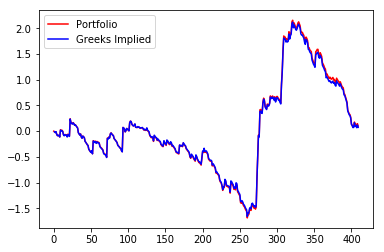

In [25]:
plt.plot(list(range(len(Strategy))), Strategy.Portfolio, 'r', label = 'Portfolio')
plt.plot(list(range(len(Strategy))), Others.After_hedge.cumsum(), 'b', label = 'Greeks Implied')
plt.legend()
plt.show()

2) Theta is increasing at a really low speed and is almost constant, same as it's contribution. This is the amount that we are losing in the option price due to time decay. For a single stock option with our setup, every day we are giving away 0.2-0.4 dollar profit, this is quite a big amount. And remember, our setup is a very long-dated option, through our backtesting the time to maturity spans from 20 months to 2 months. Theta would be larger for short dated options, and this is also reflected in the data. Note that the frequent spikes are weekends, as they are also counted as time elapsed.

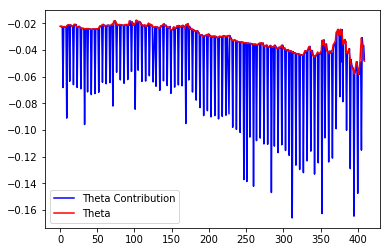

In [26]:
plt.plot(list(range(len(Strategy))), Others.Theta_Con, 'b', label = 'Theta Contribution')
plt.plot(list(range(len(Strategy))), Greeks.Theta/365, 'r', label = 'Theta')
plt.legend()
plt.show()

3) Similar to theta, the option or portfolio gamma is increasing at a low speed as well, but the gamma contribution to PNL is much more volatile than theta contribution. This is very easy to understand, as gamma contribution = gamma * (stock change)^2 / 2, so the key is how much stock price actually changed. Another interesting finding is, (stock price diff)^2 has been frequently regarded as volatility in mathematical finance, so gamma contribution is actually related to realized stock volatility.

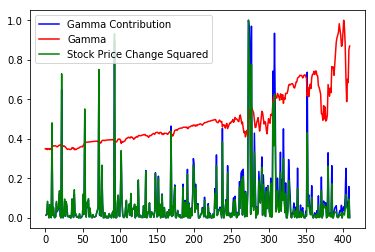

In [27]:
plt.plot(list(range(len(Strategy))), Others.Gamma_Con / Others.Gamma_Con.max(), 'b', label = 'Gamma Contribution')
plt.plot(list(range(len(Strategy))), Greeks.Gamma / Greeks.Gamma.max(), 'r', label = 'Gamma')
plt.plot(list(range(len(Strategy))), Others.Stock_Price_Change ** 2 / (Others.Stock_Price_Change ** 2).max(),\
                                                 'g', label = 'Stock Price Change Squared')
plt.legend()
plt.show()

Now, it seems "gamma scalping" or profitting from dynamically hedgin delta is really just betting against realized volatility, but hoping the realized volatility would be big enough to cover the theta losses for the time we waited. From this information, we can infer other guesses with this strategy. 

For the purpose of some parameter tweeking tests, I'll use an third party library to save some time of diddling the market object.

In [28]:
import mibian

Implied vol plays an important role of how this strategy performs. 

With the same stock time series, Gamma pnl depends only on gamma values, in other words, the larger gamma is, the more gamma pnl we will see. Obviously gamma depends on implied vol. Usually, with larger implied vol, we'll see smaller gamma according to the formula. A complete relationship looks like below. So, we can probably say, the more volatility has been priced in (throuh implied vol), the more realized volatility has to acheive in order to make gamma scalping profitable.

Opposite thing with Theta. Theta grows in absolute value with implied vol, which means with more implied vol, we lose more money due to time decay as we wait. Together we can see, higher implied volatility will hurt the performance of delta hedging strategy.

In [29]:
test1 = {}
test1['implied_vol'] = np.linspace(0.5, 50, 100)
test1['gamma'] = [mibian.BS([100,100,1,365],iv).gamma for iv in test1['implied_vol']]
test1['theta'] = [mibian.BS([100,100,1,365],iv).callTheta for iv in test1['implied_vol']]

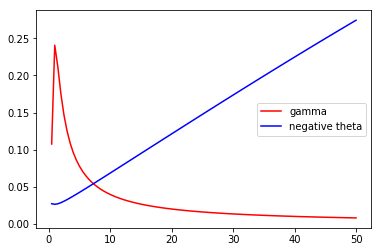

In [30]:
plt.plot(test1['implied_vol'], test1['gamma'], 'r', label = 'gamma')
plt.plot(test1['implied_vol'], [-10*x for x in test1['theta']], 'b', label = 'negative theta')
plt.legend()
plt.show()

To verify that, we run the whole analysis again with a 10% implied vol setup. We expect the strategy performance will be improved.

In [31]:
iv = lambda x: 0.10
for t in data.index:
    t = pd.Timestamp(t)
    implied_vol[t] = iv
market.save_data(implied_vol, 'GS_IV', over_write = True)

Over writing GS_IV!


In [32]:
Strategy2 = pd.DataFrame(np.NaN, index = data.index, 
                        columns = ['Option', 'Stock', 'Cash', 'Portfolio'])

In [33]:
Greeks2 = pd.DataFrame(np.NaN, index = data.index, 
                      columns = ['Price', 'Delta', 'Gamma','Theta'])
for i, date_idx in enumerate(Greeks2.index):
    Greeks2.iloc[i,:].Price = Option.dollar_price(date_idx)
    Greeks2.iloc[i,:].Delta = Option.delta(date_idx)
    Greeks2.iloc[i,:].Gamma = Option.gamma(date_idx)
    Greeks2.iloc[i,:].Theta = Option.theta(date_idx)

In [34]:
for i, date_idx in enumerate(Strategy2.index):
    """
    We maintain 1 unit long call, and apply dynamic hedging of delta for each day.
    Assume on day 1 we have a 0 worth portfolio, financing any trade with cash.
    """
    Strategy2.iloc[i,:].Option = Greeks2.loc[date_idx, 'Price']
    hedge = - Greeks2.loc[date_idx, 'Delta']
    Strategy2.iloc[i,:].Stock = hedge * Stock.spot(date_idx)
    if i == 0:
        Strategy2.iloc[i,:].Cash = 0 - Strategy2.iloc[i,:].Option - Strategy2.iloc[i,:].Stock
    else:
        Strategy2.iloc[i,:].Cash = Strategy2.iloc[i-1,:].Cash - \
                                    (hedge - (-Greeks2.iloc[i-1,:].Delta)) * Stock.spot(date_idx)
    Strategy2.iloc[i,-1] = sum(Strategy2.iloc[i,:-1])

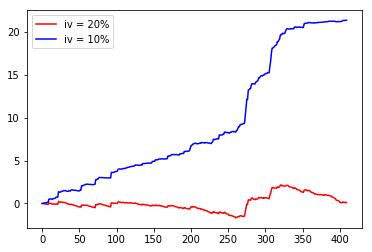

In [35]:
plt.plot(range(len(Strategy)), Strategy.Portfolio, 'r', label = 'iv = 20%')
plt.plot(range(len(Strategy)), Strategy2.Portfolio, 'b', label = 'iv = 10%')
plt.legend()
plt.show()

 As expected, performance increased a lot! Now we can pretty much say that gamma scalping is betting on realized volatility greater than the current market implied volatility, and the enemy of it is the theta or time decay.

In the above analysis, we assumed constant interest rate, dividend yield and implied volatility. In reality, interest rate and dividend yield should remain almost constant for stocks, so we are good with those assumptions, but implied volatility are known for moving around. (VIX is a good reflection of all that.) As result, the analysis above cannot represent how gamma scalping really works in the market, and I'll test that with real data in a separate exercise.